In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras import utils
import tensorflow as tf
from keras import Sequential, layers, models
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, matthews_corrcoef
)

2024-08-22 15:04:24.305961: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 15:04:24.355326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 15:04:24.401563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 15:04:24.414510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 15:04:24.459411: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf
import gc

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Memory growth has been set for GPU.")
    except RuntimeError as e:
        print(e)

# Clear TensorFlow session
tf.keras.backend.clear_session()

# Optionally, delete the model and other variables
#del model

# Force garbage collection
gc.collect()

# If you're using TensorFlow 2.x and want to clear GPU memory, you can reset the context:
tf.config.experimental.reset_memory_stats(device='GPU:0')

print("GPU memory has been cleared.")


Memory growth has been set for GPU.


I0000 00:00:1724331866.231838 3157463 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724331866.313157 3157463 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724331866.313376 3157463 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724331866.513698 3157463 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

GPU memory has been cleared.


I0000 00:00:1724331866.513900 3157463 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724331866.513967 3157463 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724331866.585363 3157463 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724331866.585613 3157463 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### Defining the Modell

In [18]:
def create_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=32, kernel_size=3, activation='sigmoid'))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=64, kernel_size=3, activation='sigmoid'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(2, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# XRan Dataset

### Load the Datasets

In [4]:
# Load the data
benign_data = pd.read_csv('../datasets/xran/benign/Benign.csv', delimiter=';', low_memory=False)
isot_data = pd.read_csv('../datasets/xran/ransomware/ISOT.csv', delimiter=';', low_memory=False)
sorel20m_data = pd.read_csv('../datasets/xran/ransomware/Sorel20M.csv', delimiter=';', low_memory=False)
virusshare_data = pd.read_csv('../datasets/xran/ransomware/VirusShare.csv', delimiter=';', low_memory=False)

# Function to process and encode sequences
def process_sequences(data, encoder, api_length=500, dll_length=10, mutex_length=10):
    # Extract API calls, DLLs, and Mutexes
    api_calls = data.filter(regex='ApiCall_').values
    dlls = data.filter(regex='Dll_').values
    mutexes = data.filter(regex='Mutex_').values

    # Truncate or pad sequences
    api_calls = [list(row)[:api_length] + [''] * (api_length - len(row)) for row in api_calls]
    dlls = [list(row)[:dll_length] + [''] * (dll_length - len(row)) for row in dlls]
    mutexes = [list(row)[:mutex_length] + [''] * (mutex_length - len(row)) for row in mutexes]

    # Combine sequences
    combined_sequences = [api + dll + mutex for api, dll, mutex in zip(api_calls, dlls, mutexes)]
    
    # Flatten the list of sequences to fit label encoder requirements
    flat_sequences = [item for sublist in combined_sequences for item in sublist]
    
    # Encode the sequences    
    encoded_sequences = encoder.fit_transform(flat_sequences)
    
    # Reshape back to the original structure
    encoded_sequences = np.reshape(encoded_sequences, (len(combined_sequences), api_length + dll_length + mutex_length))
    
    return encoded_sequences, encoder

# Process the datasets
encoder = LabelEncoder()

benign_sequences, encoder = process_sequences(benign_data, encoder)
isot_sequences, _ = process_sequences(isot_data, encoder)
sorel20m_sequences, _ = process_sequences(sorel20m_data, encoder)
virusshare_sequences, _ = process_sequences(virusshare_data, encoder)

# Convert to DataFrame for further use
benign_df = pd.DataFrame(benign_sequences)
isot_df = pd.DataFrame(isot_sequences)
sorel20m_df = pd.DataFrame(sorel20m_sequences)
virusshare_df = pd.DataFrame(virusshare_sequences)

# Add labels
benign_df['label'] = 0
isot_df['label'] = 1
sorel20m_df['label'] = 1
virusshare_df['label'] = 1

In [82]:
benign_df.head()

,0,1,2,3,4,5,6,7,8,9,...,511,512,513,514,515,516,517,518,519,label
0,1638,1638,1638,1638,1638,1638,1638,1638,1638,1638,...,1923,1926,1341,1344,1343,1342,1924,1927,1928,0
1,1638,1638,1638,1638,1638,1638,1638,1638,1638,1638,...,2658,2658,2658,2658,2658,2658,2658,2658,2658,0
2,639,1231,1232,1232,1232,1232,1232,1232,1232,1232,...,716,706,715,1325,705,711,717,707,708,0
3,1638,1638,1638,1638,1638,1638,1546,1559,1546,625,...,2658,2658,2658,2658,2658,2658,2658,2658,2658,0
4,639,1546,1559,1546,1231,1232,1232,1232,1232,1231,...,2658,2658,2658,2658,2658,2658,2658,2658,2658,0


### Combine the Datasets and shuffel it

In [5]:
# Combine datasets
combined_df = pd.concat([benign_df, isot_df, sorel20m_df, virusshare_df], ignore_index=True)

# Shuffle the combined dataset
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,511,512,513,514,515,516,517,518,519,label
0,639,1937,1930,620,620,429,429,429,429,1547,...,2658,2658,2658,2658,2658,2658,2658,2658,2658,0
1,639,1937,1930,620,620,429,429,429,429,1547,...,2658,2658,2658,2658,2658,2658,2658,2658,2658,0
2,1233,1232,1234,1233,1232,1930,579,1958,1241,579,...,1293,1340,1348,2567,2519,1337,1338,1349,1346,0
3,285,2194,2209,2194,1980,1981,1981,1981,1981,1980,...,2625,2625,2625,2625,2625,2625,2625,2625,2625,1
4,1930,1548,1546,1546,1932,1582,1932,1582,1932,1582,...,2658,2658,2658,2658,2658,2658,2658,2658,2658,0


### Split the data into Train and Test Data

In [6]:
# Split features and labels
data = combined_df.drop('label', axis=1).values
lables = combined_df['label'].values

# Reshape data for CNN input
data = np.expand_dims(data, axis=-1)

# Convert labels to categorical
lables = utils.to_categorical(lables, num_classes=2)

# Train/test split
data_train, data_tmp, lables_train, lables_tmp = train_test_split(data, lables, test_size=0.4, random_state=42)
data_test, data_val, lables_test, lables_val = train_test_split(data_tmp, lables_tmp, test_size=0.5, random_state=42)

# Display shapes of the datasets
print(f"Training data shape: {data_train.shape}")
print(f"Test data shape: {data_test.shape}")
print(f"Validation data shape: {data_val.shape}")

Training data shape: (18102, 520, 1)
Test data shape: (6034, 520, 1)
Validation data shape: (6035, 520, 1)


### Train the Model

In [312]:
input_shape = (data_train.shape[1], 1)

# Create the model
model = create_model(input_shape)
model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_85 (Conv1D)              │ (None, 518, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 518, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_86 (Conv1D)              │ (None, 516, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 516, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 33024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │     2,113,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,120,066 (8.09 MB)

 Trainable params: 2,120,066 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [313]:
# Train the model
model.fit(data_train, lables_train, epochs=100, batch_size=32, validation_data=(data_val, lables_val))

# Evaluate the model
loss, accuracy = model.evaluate(data_val, lables_val)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7180 - loss: 3.7068 - val_accuracy: 0.9577 - val_loss: 0.1186
Epoch 2/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9540 - loss: 0.1216 - val_accuracy: 0.9708 - val_loss: 0.0806
Epoch 3/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9599 - loss: 0.0983 - val_accuracy: 0.9665 - val_loss: 0.0845
Epoch 4/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9655 - loss: 0.0848 - val_accuracy: 0.9705 - val_loss: 0.0755
Epoch 5/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9625 - loss: 0.0911 - val_accuracy: 0.9695 - val_loss: 0.0754
Epoch 6/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9708 - loss: 0.0672 - val_accuracy: 0.9829 - val_loss: 0.0653
Epoch 7/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9705 - loss: 0.0682 - val_accuracy: 0.9793 - val_loss: 0.0546
Epoch 8/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9718 - loss: 0.0706 - val_accu

In [322]:
model.save('xran.keras')

### Results

In [7]:
model = models.load_model('xran.keras', compile=True)
model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_85 (Conv1D)              │ (None, 518, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 518, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_86 (Conv1D)              │ (None, 516, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 516, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 33024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │     2,113,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,360,200 (24.26 MB)

 Trainable params: 2,120,066 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,240,134 (16.17 MB)

In [8]:
# Predict probabilities
y_pred_prob = model.predict(data_test)
y_pred_prob = y_pred_prob[:, 1]
# Get true labels
y_true_class = np.argmax(lables_test, axis=1)

# Separate probabilities by true class
benign_probs = y_pred_prob[y_true_class == 0]
ransomware_probs = y_pred_prob[y_true_class == 1]

I0000 00:00:1724331675.308333 3154829 service.cc:146] XLA service 0x7646c8004690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724331675.308438 3154829 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-08-22 15:01:15.335229: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-22 15:01:15.410027: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


141/189 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step

I0000 00:00:1724331675.924191 3154829 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


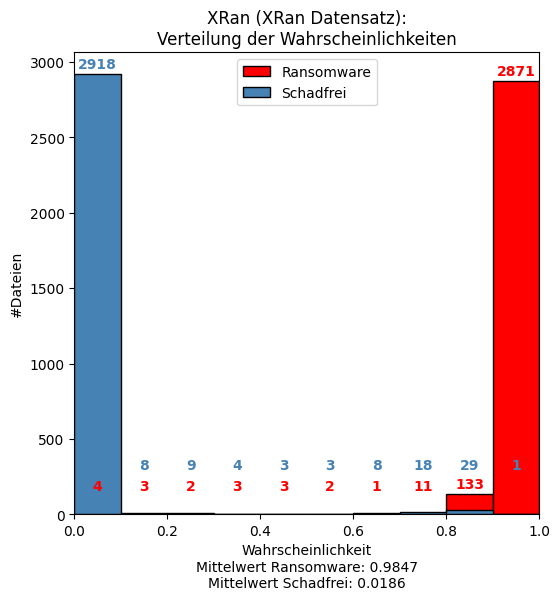

In [325]:
plt.style.use('default')
plt.figure(figsize=(6, 6))

# Plot histogram of probabilities for each class
_, _, ransom_bars = plt.hist(ransomware_probs, label="Ransomware", range=(0,1), color='red', edgecolor='black')
_, _, benign_bars = plt.hist(benign_probs, label='Schadfrei', range=(0,1), color='steelblue', edgecolor='black')

plt.title(f'XRan (XRan Datensatz):\nVerteilung der Wahrscheinlichkeiten')
plt.xlabel(f'Wahrscheinlichkeit\nMittelwert Ransomware: {ransomware_probs.mean():.4f}\nMittelwert Schadfrei: {benign_probs.mean():.4f}')

for bar in ransom_bars:
    if bar.get_height() < 120:
        plt.text(bar.get_x() + bar.get_width() / 2, 160, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 40, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')

for bar in benign_bars:
    if bar.get_height() < 100:
        plt.text(bar.get_x() + bar.get_width() / 2, 300, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 40, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')

plt.legend()
plt.xlim(0, 1)
plt.ylabel('#Dateien')
plt.show()

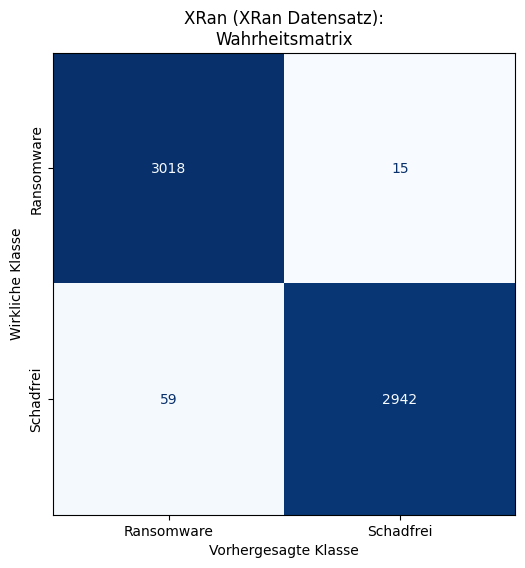

In [317]:
# Predict classes
y_pred_class = (y_pred_prob > 0.5).astype(int).flatten()
y_true_class = np.argmax(lables_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class)
# Reorder confusion matrix to switch classes
cm = cm[[1, 0], :]  # Switch the rows
cm = cm[:, [1, 0]]  # Switch the columns

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ransomware', 'Schadfrei'])

fig, ax = plt.subplots(figsize=(6, 6))
# Plot confusion matrix
cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title('XRan (XRan Datensatz):\nWahrheitsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wirkliche Klasse')
# Rotate x and y axis labels
plt.yticks(rotation=90, va='center')
plt.show()

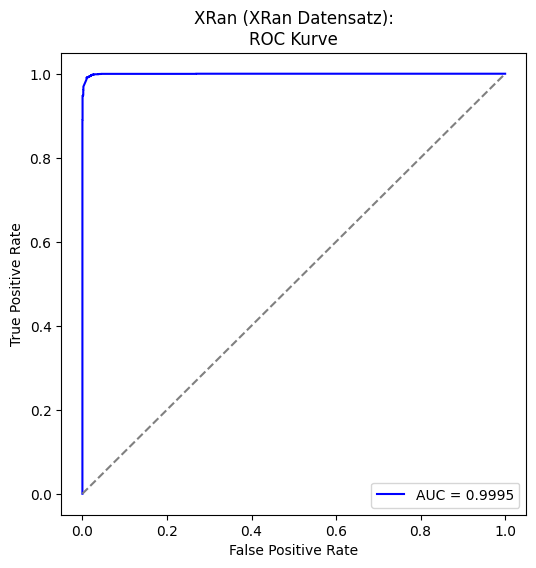

Bester Grenzwert: 0.7993332743644714


In [318]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_class, y_pred_prob)

# Calculate AUC
auc = roc_auc_score(y_true_class, y_pred_prob)

# Find the best threshold
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]


# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XRan (XRan Datensatz):\nROC Kurve')
plt.legend(loc='lower right')
plt.show()

# Print the best threshold
print(f'Bester Grenzwert: {best_threshold}')

In [319]:
# Calculate and display classification metrics
accuracy = accuracy_score(y_true_class, y_pred_class)
recall = recall_score(y_true_class, y_pred_class)
precision = precision_score(y_true_class, y_pred_class)
f1 = f1_score(y_true_class, y_pred_class)
mcc = (matthews_corrcoef(y_true_class, y_pred_class) + 1) / 2
wertung = 0.5 * recall + 0.25 * f1 + 0.125 * auc + 0.125 * mcc
report = classification_report(y_true_class, y_pred_class, target_names=['Benign', 'Ransomware'], digits=4)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'Wertung: {wertung:.4f}')
print('\nDetailed Classification Report:')
print(report)

Accuracy: 0.9877
Recall (Sensitivity): 0.9951
Precision: 0.9808
F1-Score: 0.9879
AUC: 0.9995
MCC: 0.9878
Wertung: 0.9929

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign     0.9949    0.9803    0.9876      3001
  Ransomware     0.9808    0.9951    0.9879      3033

    accuracy                         0.9877      6034
   macro avg     0.9879    0.9877    0.9877      6034
weighted avg     0.9878    0.9877    0.9877      6034



# PE-Header Dataset

In [24]:
# Load the CSV file
pe_df = pd.read_csv('../datasets/peheaders/Ransomware_headers.csv')

X_train = np.array([])
y_train = np.array([])

# Iterate over the dataframe rows to create and save images
for index, row in pe_df.iterrows():
    # Extract the byte sequence (columns 5 to 1028)
    byte_sequence = row[4:].values
    byte_sequence = np.array(byte_sequence, dtype=np.uint8)
    label = row['GR']

    y_train = np.append(y_train, label)
    X_train = np.append(X_train, byte_sequence)

X_train = X_train.reshape(-1, 1024)

# Reshape data for CNN input
X_train = np.expand_dims(X_train, axis=-1)
# Convert labels to categorical
y_train = utils.to_categorical(y_train, num_classes=2)

# Split the dataset into training (60%) and temporary (40%) datasets
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.4, random_state=42, stratify=y_train)

# Split the temporary dataset into validation (20%) and test (20%) datasets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)


Training set size: (1294, 1024, 1) (1294, 2)
Validation set size: (431, 1024, 1) (431, 2)
Test set size: (432, 1024, 1) (432, 2)


### Train the Model

In [28]:
pe_input_shape = (X_train.shape[1], 1)

# Create the model
pe_model = create_model(pe_input_shape)
pe_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 1022, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1022, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 1020, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1020, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 65280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     4,177,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,184,450 (15.96 MB)

 Trainable params: 4,184,450 (15.96 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
pe_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = pe_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5337 - loss: 33.1513 - val_accuracy: 0.7842 - val_loss: 2.3097
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6866 - loss: 1.6330 - val_accuracy: 0.7471 - val_loss: 0.7500
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6786 - loss: 1.0402 - val_accuracy: 0.6404 - val_loss: 1.0356
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7939 - loss: 0.5790 - val_accuracy: 0.6357 - val_loss: 0.9939
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7401 - loss: 0.6721 - val_accuracy: 0.4919 - val_loss: 1.7230
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7794 - loss: 0.6609 - val_accuracy: 0.8492 - val_loss: 0.3971
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8798 - loss: 0.3524 - val_accuracy: 0.7749 - val_loss: 0.5769
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8411 - loss: 0.3938 - val_accuracy: 0.8701 -

In [30]:
pe_model.save('xran_pe.keras')

In [ ]:
pe_model = models.load_model('xran_rd.keras', compile=True)
pe_model.summary()

In [31]:
# Predict probabilities
y_pred_prob = pe_model.predict(X_test)

# Get true labels
y_true_class = np.argmax(y_test, axis=1)
y_pred_prob = y_pred_prob[:, 1]

# Separate probabilities by true class
benign_probs = y_pred_prob[y_true_class == 0]
ransomware_probs = y_pred_prob[y_true_class == 1]

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


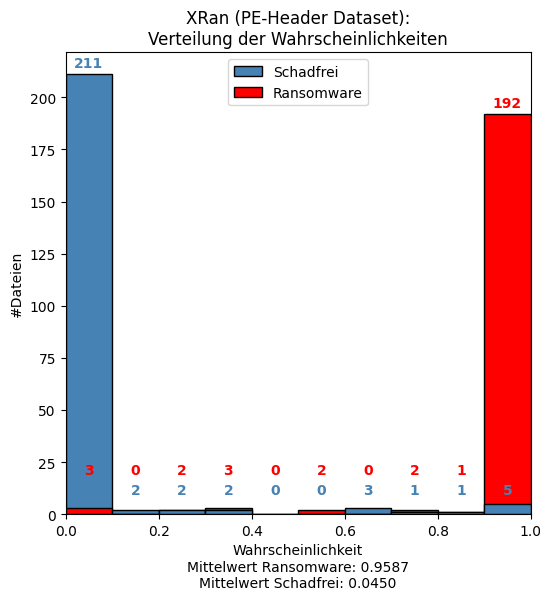

In [39]:
plt.style.use('default')
plt.figure(figsize=(6, 6))

# Calculate histogram data
bins = np.linspace(0, 1, 11)  # 10 bins from 0 to 1
ransom_hist, _ = np.histogram(ransomware_probs, bins=bins)
benign_hist, _ = np.histogram(benign_probs, bins=bins)

# Determine which histogram has smaller values for each bin
smaller_on_top = ransom_hist < benign_hist

# Plot bars
x = (bins[:-1] + bins[1:]) / 2  # Center of each bin
width = np.diff(bins)

for i in range(len(x)):
    if smaller_on_top[i]:
        plt.bar(x[i], benign_hist[i], width[i], color='steelblue', edgecolor='black', label='Schadfrei' if i == 0 else '')
        plt.bar(x[i], ransom_hist[i], width[i], color='red', edgecolor='black', label='Ransomware' if i == 0 else '')
    else:
        plt.bar(x[i], ransom_hist[i], width[i], color='red', edgecolor='black', label='Ransomware' if i == 0 else '')
        plt.bar(x[i], benign_hist[i], width[i], color='steelblue', edgecolor='black', label='Schadfrei' if i == 0 else '')

plt.title('XRan (PE-Header Dataset):\nVerteilung der Wahrscheinlichkeiten')
plt.xlabel(f'Wahrscheinlichkeit\nMittelwert Ransomware: {ransomware_probs.mean():.4f}\nMittelwert Schadfrei: {benign_probs.mean():.4f}')

# Add text labels
for i, (ransom_count, benign_count) in enumerate(zip(ransom_hist, benign_hist)):
    if ransom_count < 60:
        plt.text(x[i], 18, f'{int(ransom_count)}', ha='center', va='bottom', color='red', fontweight='bold')
    else:
        plt.text(x[i], ransom_count + 2, f'{int(ransom_count)}', ha='center', va='bottom', color='red', fontweight='bold')
    
    if benign_count < 50:
        plt.text(x[i], 8, f'{int(benign_count)}', ha='center', va='bottom', color='steelblue', fontweight='bold')
    else:
        plt.text(x[i], benign_count + 2, f'{int(benign_count)}', ha='center', va='bottom', color='steelblue', fontweight='bold')

plt.legend()
plt.xlim(0, 1)
plt.ylabel('#Dateien')
plt.show()

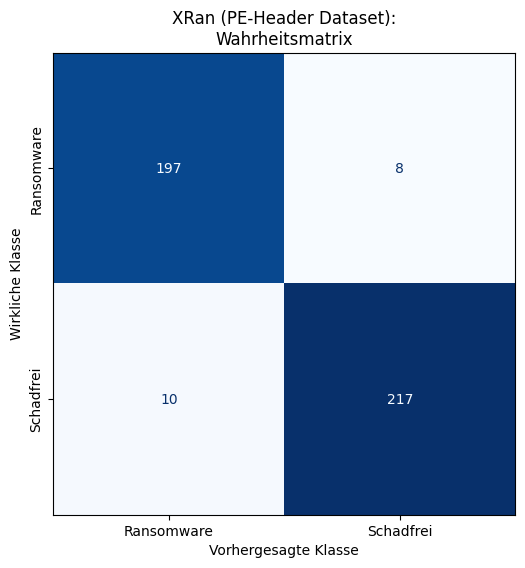

In [41]:
# Predict classes
y_pred_class = (y_pred_prob > 0.5).astype(int).flatten()
y_true_class = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_class, y_pred_class)
# Reorder confusion matrix to switch classes
cm = cm[[1, 0], :]  # Switch the rows
cm = cm[:, [1, 0]]  # Switch the columns

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ransomware', 'Schadfrei'])

fig, ax = plt.subplots(figsize=(6, 6))
# Plot confusion matrix
cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title('XRan (PE-Header Dataset):\nWahrheitsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wirkliche Klasse')
# Rotate x and y axis labels
plt.yticks(rotation=90, va='center')
plt.show()

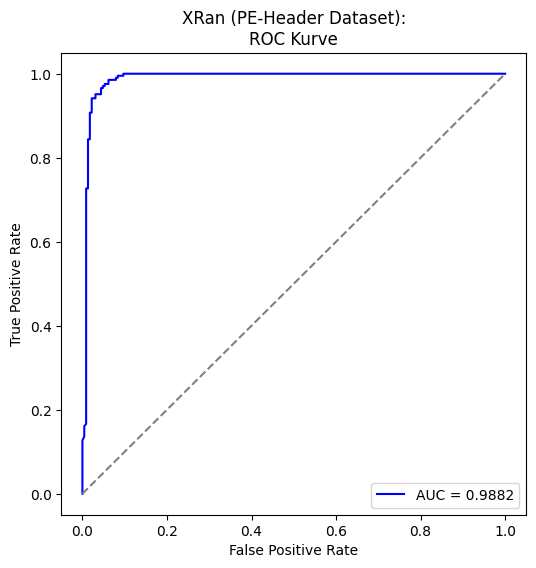

Bester Grenzwert: 0.20063279569149017


In [45]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_class, y_pred_prob)

# Calculate AUC
auc = roc_auc_score(y_true_class, y_pred_prob)

# Find the best threshold
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]


# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XRan (PE-Header Dataset):\nROC Kurve')
plt.legend(loc='lower right')
plt.show()

# Print the best threshold
print(f'Bester Grenzwert: {best_threshold}')

In [44]:
# Calculate and display classification metrics
accuracy = accuracy_score(y_true_class, y_pred_class)
recall = recall_score(y_true_class, y_pred_class)
precision = precision_score(y_true_class, y_pred_class)
f1 = f1_score(y_true_class, y_pred_class)
mcc = (matthews_corrcoef(y_true_class, y_pred_class) + 1) / 2
wertung = 0.5 * recall + 0.25 * f1 + 0.125 * auc + 0.125 * mcc
report = classification_report(y_true_class, y_pred_class, target_names=['Benign', 'Ransomware'], digits=4)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'Wertung: {wertung:.4f}')
print('\nDetailed Classification Report:')
print(report)

Accuracy: 0.9583
Recall (Sensitivity): 0.9610
Precision: 0.9517
F1-Score: 0.9563
AUC: 0.9882
MCC: 0.9583
Wertung: 0.9629

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign     0.9644    0.9559    0.9602       227
  Ransomware     0.9517    0.9610    0.9563       205

    accuracy                         0.9583       432
   macro avg     0.9581    0.9585    0.9582       432
weighted avg     0.9584    0.9583    0.9583       432



# Ransomware Dataset 2016

In [4]:
# Load the data
rd_data = pd.read_csv('../datasets/ransomwaredataset2016/RansomwareData.csv', low_memory=False, header=None)

# Shuffle the dataset
rd_data_df = rd_data.sample(frac=1).reset_index(drop=True)
rd_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,30960,30961,30962,30963,30964,30965,30966,30967,30968,30969
0,20081,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20914,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10854,1,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,21083,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20696,0,0,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
rd_data = rd_data_df.drop(1, axis=1).values
rd_lables = rd_data_df[1].values

# Reshape data for CNN input
rd_data = np.expand_dims(rd_data, axis=-1)

# Convert labels to categorical
rd_lables = utils.to_categorical(rd_lables, num_classes=2)

# Train/test/val 0.6/0.2/0.2 split
rd_data_train, rd_data_tmp, rd_lables_train, rd_lables_tmp = train_test_split(rd_data, rd_lables, test_size=0.4, random_state=42)
rd_data_val, rd_data_test, rd_lables_val, rd_lables_test = train_test_split(rd_data_tmp, rd_lables_tmp, test_size=0.5, random_state=42)

# Display shapes of the datasets
print(f'Train: {rd_data_train.shape}, {rd_lables_train.shape}')
print(f'Validation: {rd_data_val.shape}, {rd_lables_val.shape}')
print(f'Test: {rd_data_test.shape}, {rd_lables_test.shape}')

Train: (914, 30969, 1), (914, 2)
Validation: (305, 30969, 1), (305, 2)
Test: (305, 30969, 1), (305, 2)


In [6]:
input_shape = (rd_data_train.shape[1], 1)

# Create the model
rd_model = create_model(input_shape)
rd_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30967, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30967, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30965, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30965, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1981760)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │   126,832,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,839,170 (483.85 MB)

 Trainable params: 126,839,170 (483.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
rd_model.fit(rd_data_train, rd_lables_train, epochs=100, batch_size=32, validation_data=(rd_data_val, rd_lables_val))

# Evaluate the model
loss, accuracy = rd_model.evaluate(rd_data_val, rd_lables_val)
print(f'Loss: {loss}, Accuracy: {accuracy}')

In [9]:
rd_model.save('xran_rd.keras')

In [6]:
rd_model = models.load_model('xran_rd.keras', compile=True)
rd_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30967, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30967, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30965, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30965, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1981760)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │   126,832,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,517,512 (1.42 GB)

 Trainable params: 126,839,170 (483.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 253,678,342 (967.71 MB)

In [12]:
# Predict probabilities
y_pred_prob = rd_model.predict(rd_data_test)

# Get true labels
y_true_class = np.argmax(rd_lables_test, axis=1)
y_pred_prob = y_pred_prob[:, 1]

# Separate probabilities by true class
benign_probs = y_pred_prob[y_true_class == 0]
ransomware_probs = y_pred_prob[y_true_class == 1]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


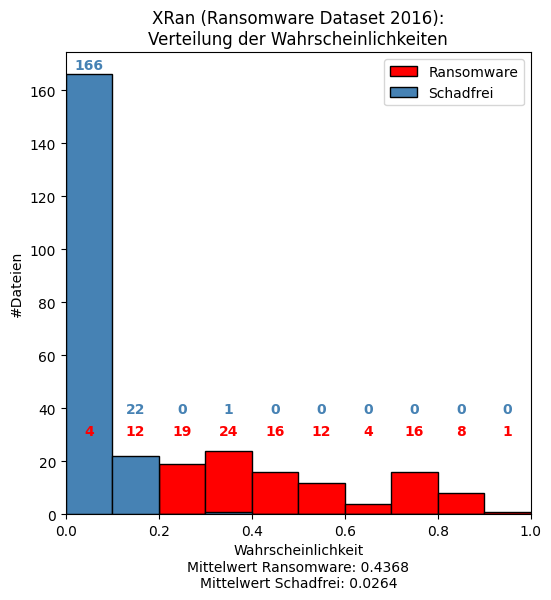

In [13]:
plt.style.use('default')
plt.figure(figsize=(6, 6))

# Plot histogram of probabilities for each class
_, _, ransom_bars = plt.hist(ransomware_probs, label="Ransomware", range=(0,1), color='red', edgecolor='black')
_, _, benign_bars = plt.hist(benign_probs, label='Schadfrei', range=(0,1), color='steelblue', edgecolor='black')

plt.title(f'XRan (Ransomware Dataset 2016):\nVerteilung der Wahrscheinlichkeiten')
plt.xlabel(f'Wahrscheinlichkeit\nMittelwert Ransomware: {ransomware_probs.mean():.4f}\nMittelwert Schadfrei: {benign_probs.mean():.4f}')

for bar in ransom_bars:
    if bar.get_height() < 30:
        plt.text(bar.get_x() + bar.get_width() / 2, 30, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')

for bar in benign_bars:
    if bar.get_height() < 30:
        plt.text(bar.get_x() + bar.get_width() / 2, 38, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')

plt.legend()
plt.xlim(0, 1)
plt.ylabel('#Dateien')
plt.show()

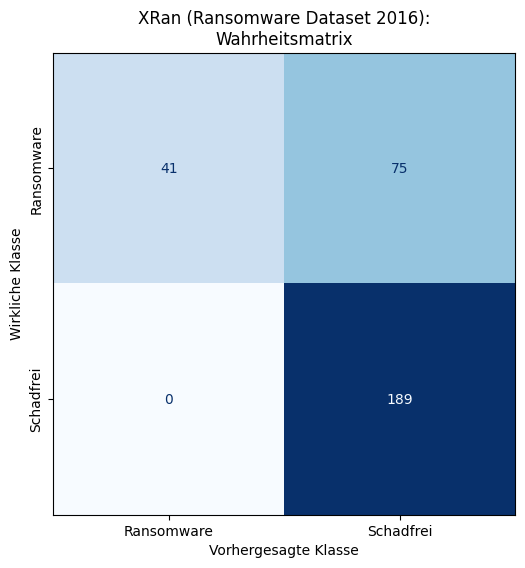

In [14]:
# Predict classes
y_pred_class = (y_pred_prob > 0.5).astype(int).flatten()
y_true_class = np.argmax(rd_lables_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class)
# Reorder confusion matrix to switch classes
cm = cm[[1, 0], :]  # Switch the rows
cm = cm[:, [1, 0]]  # Switch the columns

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ransomware', 'Schadfrei'])

fig, ax = plt.subplots(figsize=(6, 6))
# Plot confusion matrix
cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title('XRan (Ransomware Dataset 2016):\nWahrheitsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wirkliche Klasse')
# Rotate x and y axis labels
plt.yticks(rotation=90, va='center')
plt.show()

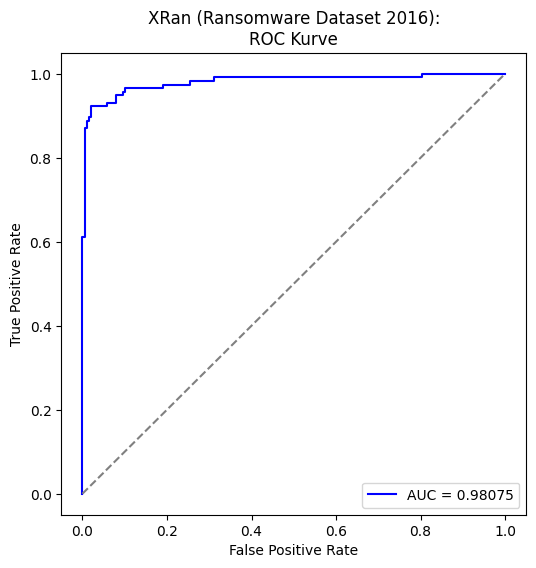

Bester Grenzwert: 0.16850894689559937


In [15]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_class, y_pred_prob)

# Calculate AUC
auc = roc_auc_score(y_true_class, y_pred_prob)

# Find the best threshold
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.5f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XRan (Ransomware Dataset 2016):\nROC Kurve')
plt.legend(loc='lower right')
plt.show()

# Print the best threshold
print(f'Bester Grenzwert: {best_threshold}')

In [16]:
# Calculate and display classification metrics
accuracy = accuracy_score(y_true_class, y_pred_class)
recall = recall_score(y_true_class, y_pred_class)
precision = precision_score(y_true_class, y_pred_class)
f1 = f1_score(y_true_class, y_pred_class)
mcc = (matthews_corrcoef(y_true_class, y_pred_class) + 1) / 2
wertung = 0.5 * recall + 0.25 * f1 + 0.125 * auc + 0.125 * mcc
report = classification_report(y_true_class, y_pred_class, target_names=['Benign', 'Ransomware'], digits=4)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'Wertung: {wertung:.4f}')
print('\nDetailed Classification Report:')
print(report)

Accuracy: 0.7541
Recall (Sensitivity): 0.3534
Precision: 1.0000
F1-Score: 0.5223
AUC: 0.9808
MCC: 0.7515
Wertung: 0.5238

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign     0.7159    1.0000    0.8344       189
  Ransomware     1.0000    0.3534    0.5223       116

    accuracy                         0.7541       305
   macro avg     0.8580    0.6767    0.6784       305
weighted avg     0.8240    0.7541    0.7157       305

